In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Define optical flow computation

Functions to compute optical flow pairs and to visualise them.

In [3]:
def compute_flow_pair(frame1_gray, frame2_gray):
    # Computes dense optical flow using the Farneback algorithm
    flow = cv2.calcOpticalFlowFarneback(frame1_gray, frame2_gray, 
                                        None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

In [4]:
def flow2img(flow):
    flow_img = np.zeros_like(flow)
    cv2.normalize(flow, flow_img, 0, 255, cv2.NORM_MINMAX)
    return flow_img

In [5]:
def compute_and_show(f1_path, f2_path):
    frame1_gray = cv2.imread(f1_path, cv2.IMREAD_GRAYSCALE)
    frame2_gray = cv2.imread(f2_path, cv2.IMREAD_GRAYSCALE)
    flow = compute_flow_pair(frame1_gray, frame2_gray)
    flow_img = flow2img(flow)

    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs[0,0].imshow(frame1_gray, cmap='gray')
    axs[0,1].imshow(frame2_gray, cmap='gray')
    axs[1,0].imshow(flow_img[...,0], cmap='gray')
    axs[1,1].imshow(flow_img[...,1], cmap='gray')
    plt.show()

### Visualise optical flow

A few computations and plots to check the optical flow between consecutive pictures of the stream, in different situations.

In [6]:
enoe_dir = '/enoe'
os.listdir(enoe_dir)

['2022', '2021', '2020', '2018', '2019']

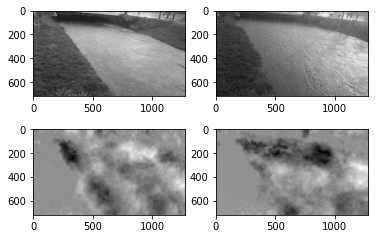

In [7]:
f1_path = os.path.join(enoe_dir, '2020/11/26/20201126_180057-SHOP2.jpg')
f2_path = os.path.join(enoe_dir, '2020/11/26/20201126_180703-SHOP2.jpg')
compute_and_show(f1_path, f2_path)

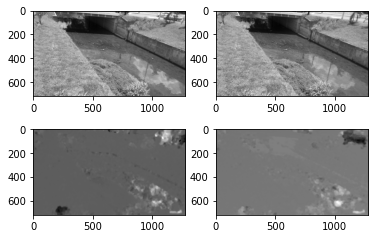

In [7]:
f1_path = os.path.join(enoe_dir, '2020/11/26/20201126_135322-SHOP2.jpg')
f2_path = os.path.join(enoe_dir, '2020/11/26/20201126_135915-SHOP2.jpg')
compute_and_show(f1_path, f2_path)

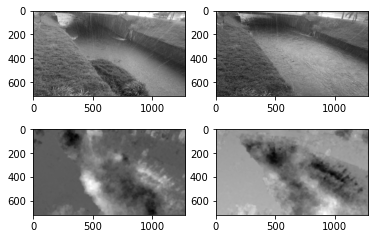

In [8]:
f1_path = os.path.join(enoe_dir, '2020/11/26/20201126_174127-SHOP2.jpg')
f2_path = os.path.join(enoe_dir, '2020/11/26/20201126_174720-SHOP2.jpg')
compute_and_show(f1_path, f2_path)

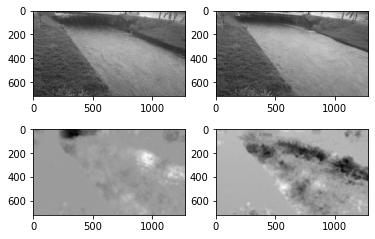

In [9]:
f1_path = os.path.join(enoe_dir, '2020/11/26/20201126_175313-SHOP2.jpg')
f2_path = os.path.join(enoe_dir, '2020/11/26/20201126_175907-SHOP2.jpg')
compute_and_show(f1_path, f2_path)

## Automate optical flow computation

Functions to automate the computations of all optical flow between consecutive frames that are less than 20 minutes away from each other (to avoid computing across gaps). A csv file is generated to keep track of annotations.

This notebook was used for testing. The code was transcripted to a Python script to actually generate all images.

In [9]:
enoe_dir = '/enoe'
csv_path = '../resources/flood_images_annot.csv'
csv_flow_path = '../resources/flood_flow_annot.csv'
flows_dir = '/flow'

os.makedirs(flows_dir, exist_ok=True)

In [10]:
import enoe_utils
import pandas as pd

# Load images dataframe
df = enoe_utils.load_df(csv_path, place='SHOP')
# Remove "bad" images (annotated as zero)
df = df[ df['level']!=0 ]
df.head()

,datetime,place,path,level
33842,2018-11-01 00:00:58,SHOP,2018/11/01/20181101_000058-SHOP.jpg,1.0
33844,2018-11-01 00:17:22,SHOP,2018/11/01/20181101_001722-SHOP.jpg,1.0
33847,2018-11-01 00:33:51,SHOP,2018/11/01/20181101_003351-SHOP.jpg,1.0
33849,2018-11-01 00:50:03,SHOP,2018/11/01/20181101_005003-SHOP.jpg,1.0
33851,2018-11-01 01:06:17,SHOP,2018/11/01/20181101_010617-SHOP.jpg,1.0


In [49]:
prev_row = None
prev_img = None
flow_df_rows = list()

# Iterrate all rows
for i, (index, row) in enumerate(df.iterrows()):
    # Read image given in the current row
    img = cv2.imread(os.path.join(enoe_dir,row['path']), cv2.IMREAD_GRAYSCALE)
    # Check if this is not the first image
    if prev_img is not None:
        # Check if the last image was taken less than 20 minutes ago
        time_diff = (row['datetime'] - prev_row['datetime']).seconds//60
        if time_diff < 20:
            # Compute optical flow, convert it into an image, and store it
            flow = compute_flow_pair(prev_img, img)
            flow_img = flow2img(flow)
            dir_name_u = os.path.dirname(os.path.join(flows_dir, 'u', row['path']))
            dir_name_v = os.path.dirname(os.path.join(flows_dir, 'v', row['path']))
            os.makedirs(dir_name_u, exist_ok=True)
            os.makedirs(dir_name_v, exist_ok=True)
            path_u = os.path.join('u', row['path'])
            path_v = os.path.join('v', row['path'])
            cv2.imwrite(os.path.join(flows_dir, path_u), flow_img[...,0])
            cv2.imwrite(os.path.join(flows_dir, path_v), flow_img[...,1])
            # Generate row for the new dataframe
            # New level = maximum level between the two frames
            new_lvl = max(row['level'], prev_row['level'])
            flow_df_rows.append([row['datetime'],
                                 row['place'],
                                 prev_row['path'],
                                 row['path'],
                                 path_u,
                                 path_v,
                                 prev_row['level'],
                                 row['level']])
    # Update prev variables
    prev_row = row
    prev_img = img
    # Show "alive" message every 500 iterations
    if not i%500:
        print(i, row)
    # Halt after 1000 iterations
    #if i==1000:
    #    break
# Generate dataframe
df_new = pd.DataFrame(flow_df_rows, columns=['datetime',
                                             'place',
                                             'path_prev',
                                             'path_next',
                                             'path_u',
                                             'path_v',
                                             'level_prev',
                                             'level_next'])
df_new.to_csv(csv_flow_path)

0 datetime                    2018-11-01 00:00:58
place                                      SHOP
path        2018/11/01/20181101_000058-SHOP.jpg
level                                       1.0
Name: 33842, dtype: object
500 datetime                    2018-11-06 12:31:58
place                                      SHOP
path        2018/11/06/20181106_123158-SHOP.jpg
level                                       1.0
Name: 34882, dtype: object
1000 datetime                    2018-11-12 04:49:29
place                                      SHOP
path        2018/11/12/20181112_044929-SHOP.jpg
level                                       1.0
Name: 35925, dtype: object
